<h1><b><center>Mecánica Celeste</center></b></h1>
<h2><b><center>Prof. Jorge I. Zuluaga</center></b></h1>
<h2><b><center>Tarea 3</center></b><h2>
<h3><b><center>La aproximación de Apophis</center></b><h3>
<h5><center><b>Asignada</b>: 19 de Septiembre de 2023</center><h5>
<h5><center><b>Entrega</b>: 3 de Octubre de 2023</center><h5>
</p>

<hr/>
<b>Nombre</b>: Sebastián Numpaque
<br/>
<b>Cédula</b>: 1002396960
<br/>
<b>Última actualización</b>: October 4, 2023
<hr/>

## Enunciado

**Objetivo**: El objetivo de esta tarea es utilizar la solución analítica del problema de los dos cuerpos para estudiar la aproximación del asteroide peligroso **99942 Apophis (2004 MN4)** durante el 13 de abril del año 2029.

**Procedimiento**:

1. Obtenga el vector de estado del asteroide Apophis el día de su cumpleaños en 2023 a las 00:00:00 UTC con respecto al Sol, así como el vector de estado de la Tierra respecto al mismo sistema de referencia.

2. Determine los elementos orbitales del asteroide y los elementos órbitales osculatrices de la Tierra usando el procedimiento aprendido en clase. Estos elementos orbitales serán los que usará a partir de ahora en todos los cálculos que use la teoría del problema de los dos cuerpos. Es importante que use el procedimiento en clase en lugar de obtener simplemente los elementos de astroquery.

3. Usando los elementos orbitales de ambos cuerpos determine la mínima distancia a la que se encontarán ambas órbitas en cualquier momento del futuro. A esta distancia se la llama MOID, por el acrónimo en inglés *Minimum orbital intersection distance*.

4. Para saber cuándo se producirá la máxima aproximación entre los dos cuerpos es necesario sin embargo resolver el problema de los dos cuerpos en el tiempo. Para ello use la ecuación de Kepler y los métodos aprendidos en clase para propagar hacia el futuro la posición de la Tierra y del asteroide en el tiempo y determinar la fecha, hora y distancia de la próxima aproximación. Para ello avance primero de mes en mes por ejemplo, y luego, cerca a la aproximación máxima, de día en día, de hora en hora, hasta encontrar el punto de mínima distancia. ¿En qué fecha, hora y distancia predice usted que se producirá la máxima aproximación?

5. Una vez encontrada la fecha y hora de la aproximación obtenida con el problema exclusivamente con la solución analítica del problema de los dos cuerpos (la que estamos viendo aquí), compárela con la que se obtiene recuperando de astroquery las posiciones de la Tierra y Apophis desde su cumpleaños hacia el futuro. Es decir, repita el procedimiento anterior, pero en lugar de obtener las posiciones a partir de la teoría del problema de los dos cuerpos, recupere las posiciones usando astroquery.  ¿Qué tan diferentes son los resultados de este procedimiento y del anterior? ¿podría explicar las discrepancias?

**Resultados esperados**:

- Este notebook con el procedimiento debidamente comentado.

- Datos mínimos:
  - MOID de la órbita de Apophis y de la Tierra calculado con la teoría del problema de los 2 cuerpos.
  - Fecha, hora y distancia mínima de aproximación calculado con la teoría del problema de los 2 cuerpos.
  - Fecha, hora y distancia mínima de aproximación calculado con los datos obtenidos de Astroqery.

- Gráficos mínimos:
  - Distancia entre Apophis y la Tierra como función del tiempo desde la fecha de nacimiento hasta la máxima aproximación, calculada con la teoría del problema de los dos cuerpos y con los datos de Astroquery.

- Gráficos opcionales:
  - Animaciones de la aproximación.

- En caso de utilizar ayudas como `ChatGPT` o códigos de `Stack Over Flow` debe citar debidamente la fuente, pero también entender a cabalidad el código, el profesor puede pedir justificación.

#**Solución**

---

Se adopta el formato de celda oculta para hacer más legible el notebook. Si este forma de presentación no es de su agrado, comunicarlo para evitar realizarlo en entregas futuras.



#**Cargue e Importe de Librerias y Módulos**

In [ ]:
# @title
!pip install -q pymcel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.9/888.9 kB 25.8 MB/s eta 0:00:00


In [ ]:
# @title
#Comunes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Astronómicas
import pymcel as pc
import spiceypy as spy
from astropy.time import Time
import astropy.constants as c
from astroquery.jplhorizons import Horizons

#Gráficos
import plotly.graph_objects as go

#Analisis de Minimos
from scipy.signal import find_peaks



---



#**Algunas Constantes y Valores**

Se definen las unidades canónicas del sistema junto con los parámetros gravitacionales de los cuerpos ($\mu$).

Se establecen algunas constantes de utilidad y se fijan transformaciones angulares que operan desde la máquina sin recurrir a funciones externas (`deg2rad` y `rad2deg`).

In [ ]:
# @title
#Constantes
day = 86400
au = c.au.value
G = c.G.value

#Unidades Canonicas
UL = 1*au
UM = c.M_sun.value
UT = (UL**3/(G*UM))**0.5
UV = UL/UT

#Parametros Gravitacionales
mu_ap = 1
mu_ea = 1 + c.GM_earth.value/(G*UM)

#Transformaciones
deg2rad = np.pi/180
rad2deg = 1/deg2rad



---



#**Horizons Query**

Se obtienen los vectores de estado de la *Tierra* y *Apophis* para el intervalo calendario entre *2023-06-30* y  *2038-06-30* que serán de utilidad en el análisis de la máxima aproximación en el tiempo.

Inicialmente se plantea estudiar la aproximación de *Apophis* para el *2029-04-19*; sin embargo, numerosos papers mencionaban una posibilidad de impacto para el *2036-04-19* [1]. Con esto en mente, nos proponemos realizar la propagación hasta dicha fecha y verificar una segunda aproximación.

Para facilitar el cálculo, se obtiene el *query* en el sistema heliocéntrico (@10). Esto nos ahorra el proceso de definir los vectores relativos, por lo que el sistema heliocéntrico se puede considerar como el espacio del vector relativo.

- [1] Peng Guo et al 2018 IOP Conf. Ser.: Mater. Sci. Eng. 468 012023. https://iopscience.iop.org/article/10.1088/1757-899X/468/1/012023/pdf

Se define la fecha de partida y la fecha de parada. También se establecen dos fechas de aproximación de *Apophis*

In [ ]:
# @title

#Fechas
jd0 = Time('2023-06-30 00:00:00').jd #Inicio
jd_f = Time('2038-06-30 00:00:00').jd #Parada

#Estimado de aproximación
jd_approach = np.array([Time('2029-04-13 00:00:00').jd,
                        Time('2036-04-13 00:00:00').jd])

/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


En estas dos celdas se constuye el array que contendrá las fechas en formato *Julian Day* para todo el intervalo establecido. Este array tiene tamaño de paso igual a 1 mes hasta que se llega al mes previo a la aproximación; en este momento el tamaño de paso se reduce a **1d** hasta el día previo a la aproximación donde el tamaño de paso se reduce a **1h**. Luego los tamaños de paso vuelven a incrementar y se repite el proceso para la segunda aproximación

In [ ]:
# @title
jds = np.linspace(jd0, jd_f, 12*15)

jds_days = np.transpose(np.linspace(jd_approach - 30,
                         jd_approach + 30, 2*30 + 1))

jds_hours = np.transpose(np.linspace(jd_approach - 1,
                         jd_approach + 1, 2*24 + 1))

In [ ]:
# @title
for i in range(2):
  j = np.argmin(np.abs(jds-jds_days[i, 0]))
  k = np.argmin(np.abs(jds_days[i]-jds_hours[i, 0]))

  days_hours = np.concatenate(
               (jds_days[i,:k], jds_hours[i], jds_days[i,k+3:])
               )

  jds = np.concatenate((jds[:j], days_hours, jds[j+3:]))

La extensión larga del array que contiene las fechas ha producido que haya una incorrecta consulta de los datos en el sistema Horizons. Por esta razón, en estas celdas realizamos una consulta progresiva y vamos almacenando la información en un matriz como inicialmente se buscaba.

Para lo anterior nos apoyamos en definir una función `state_jpl()` que recibe el `id` y `jd` que se desea consultar, y retornamos los vectores de estado correspondiente.

In [ ]:
# @title
def state_jpl(id_, jd):
  query = Horizons(
          id = id_, location = '@10', epochs = jd
          ).vectors().to_pandas()

  rvecs = query[['x','y','z']].to_numpy()
  vvecs = query[['vx','vy','vz']].to_numpy()
  return rvecs, vvecs

In [ ]:
# @title
earth_state = np.hstack(state_jpl('399', jds[:8]))
apophis_state = np.hstack(state_jpl('2004 MN4', jds[:8]))

for i in range(10):
  earth_state = np.vstack((earth_state, np.hstack(
                state_jpl('399', jds[8 + 38*i:38*(i+1) + 8])
                )))

  apophis_state = np.vstack((apophis_state, np.hstack(
                state_jpl('2004 MN4', jds[8 + 38*i:38*(i+1) + 8])
                )))

#**Elementos Orbitales**

Se define una función, `orbital_elements()`, que recibe el *query* del cuerpo a análizar junto con su parámetro gravitacional, $\mu$.

La función obtiene el vector de estado inicial del cuerpo en cuestión y calcula las cantidades necesarias para establecer los elementos orbitales que son retornados dentro de un `np.array`

Esto es el calculo de los elementos orbitales en la fecha *2023-06-30* con los que se realizarán los calculos posteriores.



In [70]:
# @title
#Función de calculo de Elementos Orbitales
def orbital_elements(state, mu):

  #Vectores de estado
  rvec = state[0][:3]*au/UL
  r = np.linalg.norm(rvec)

  vvec = state[0][3:]*(au/day)/UV

  #Vectores importantes
  hvec = np.cross(rvec, vvec)
  h = np.linalg.norm(hvec)

  evec = np.cross(vvec, hvec)/mu - rvec/r
  e = np.linalg.norm(evec)

  nvec = np.cross([0,0,1], hvec)
  n = np.linalg.norm(nvec)

  #Elementos Orbitales
  I = np.arccos(hvec[2]/h)

  Omega = np.arccos(nvec[0]/n)
  Omega = 2*np.pi - Omega if nvec[1] < 0 else Omega

  w = np.arccos(np.dot(evec, nvec)/(e*n))
  w = 2*np.pi - w if evec[2] < 0 else w

  f0 = np.arccos(np.dot(evec, rvec)/(e*r))
  f0 = 2*np.pi - f0 if hvec[2] < 0 else f0

  p = (h**2)/mu
  a = p/(1 - e**2)
  b = a*(1-e)

  nmed = ((mu/(a**3))**0.5)*rad2deg*day/UT

  #Orbital Elements
  return np.array([a, e, nmed,f0*rad2deg,
                   Omega*rad2deg, I*rad2deg,
                   w*rad2deg])

En esta celda se ejecuta la función del cálculo de elementos órbitales y se muestran los valores obtenidos dentro del siguiente `DataFrame`.

In [71]:
# @title

#Orbital Elements de la Tierra
orbel_ea = orbital_elements(earth_state, mu_ea)

#Orbital Elements de Apophis
orbel_ap = orbital_elements(apophis_state, mu_ap)

pd.DataFrame((orbel_ea, orbel_ap),
             index = ['Earth', 'Apophis'],
             columns = [
                'a (AU)', 'e', 'n (deg/d)', 'f (deg)', 'Ω (deg)', 'i(deg)', 'ω (deg)'
                ])

,a (AU),e,n (deg/d),f (deg),Ω (deg),i(deg),ω (deg)
Earth,0.999345,0.017322,0.986578,175.550795,211.276988,0.003263,250.841416
Apophis,0.922730,0.191438,1.111968,80.460357,203.957167,3.339299,126.606975




---



#**Solución a la Orbita Geométrica**

Se define una función, `orbit()`, que dados los parámetros orbitales de un cuerpo, generá la solución geómetrica para su respectiva órbita. Construyendo su matriz de transfomación, se llevan las posiciones sobre la órbita (en su sistema natural) hacia el sistema heliocéntrico y se retorna una matriz de tamaño *(N, 3)*.

Notará que la operación de transformación del sistema natural al sistema heliocéntrico puede estar invertida; no lo está:

- La transformación entre sistemas lleva la forma $\bf{r'}=M\bf{r}$; sin embargo, para vectorizar el cálculo, se tiene a $\bf{r}$ como matriz de tamaño *(N, 3)*. Esto conlleva a que para realizar correctamente la operación, se deba dar de la siguiente forma: $\bf{r'}^T=M\bf{r}^T$. Esto es equivalente a realizar las siguientes operaciones

$$\bf{r'}=\bf{r}M^T\hspace{1cm}\bf{r}=\bf{r'}M$$

La anterior convención de operación matricial (Matriz a la derecha) se utilizará de aquí en adelante. En ocasiones para vectores posición individuales que no pertenezcan a una matriz, se aplicará la notación inicial (Matriz a la izquierda).

La función recibe dos argumentos: un array que contiene los elementos orbitales, y una variable `N_fs` (abreviatura para `N` o `fs`) que puede ser tipo `int` o `np.array`. Si se recibe la variable como tipo `int`, se procede a generar los `N` puntos distribuidos uniformemente a lo largo de la órbita completa; si se recibe la variable como tipo `np.array`, se procede a calcular los valores en la orbita para los respectivos `fs` recibidos

Esto se define debido a la conveniencia de la situación entre generar posiciones especificas sobre la órbita o generar puntos de distribución uniforme.

In [ ]:
# @title
def orbit(elements, N_fs):

  #Elementos Orbitales
  a, e = elements[:2]
  p = a*(1 - e**2)
  Omega, I, w = elements[4:]*deg2rad

  #Matriz de transformación
  M = spy.eul2m(w, I, Omega, 3, 1, 3)

  if type(N_fs) == int:
    f0 = elements[2]
    fs = np.linspace(f0, f0 + 2*np.pi, N_fs)

    #Sistema de la cónica (3p == 'Triple prima')
    rs_3p = p/(1 + e*np.cos(fs))
    xs_3p = rs_3p*np.cos(fs)
    ys_3p = rs_3p*np.sin(fs)
    zs_3p = np.zeros(N_fs)

  else:
    rs_3p = p/(1 + e*np.cos(N_fs))
    xs_3p = rs_3p*np.cos(N_fs)
    ys_3p = rs_3p*np.sin(N_fs)
    zs_3p = np.zeros(len(N_fs))

  rvecs_3p = np.column_stack((xs_3p, ys_3p, zs_3p))
  rvecs = rvecs_3p @ M

  return rvecs

En esta celda se ejecuta la función `orbit()` sobre la *Tierra* y *Apophis*

In [ ]:
# @title
#Vectores de posición de la Tierra en sistema natural
rvecs_ea = orbit(orbel_ea, 360)

#Vectores de posición de Apophis en sistema natural
rvecs_ap = orbit(orbel_ap, 360)



---



#**Minimum Orbital Intersection Distance**

El método implementado para el calculo del *MOID* se fundamente en el siguiente paper:

- Wiźniowski, T., & Rickman, H. (2013). Fast Geometric Method for Calculating Accurate Minimum Orbit Intersection Distances (MOIDs). Acta Astronomica, 63(2), 293-307. https://ui.adsabs.harvard.edu/abs/2013AcA....63..293W

Sean dos cuerpos, $c_1$ y $c_2$. Este método emplea un barrido de plano meridional. El plano meridional es un plano definido para cierto valor de $f_1$ en el que se encuentra $c_1$ y $c_2$ sobre sus respectivas órbitas (Fig. 1)

Para dos órbitas cofocales, se establece como plano de referencia al plano de la órbita de $c_1$. Se deben definir entonces las coordenadas de $c_2$ sobre el sistema de $c_1$.

Sea $r_{c_{22}}$ las posiciones de $c_2$ sobre su sistema natural. La transformación desde el sistema natural de $c_2$ hasta el sistema natural de $c_1$ ($r_{c_{21}}$) se da (en convención establecida)

$$r_{c_{21}}=r_{c_{22}}M_2M_1^T$$

Haciendo un barrido sobre toda la órbita de $c_2$ para un intervalo $f_2\in[f_{02}, f_{02}+2\pi]$, se establece una proyección sobre el plano de $c_1$ por lo que se define $f_1$ como la anomalia verdadera de la proyección de $r_{c_{21}}$

$$f_1=\arctan{\frac{y_{c_{21}}}{x_{c_{21}}}}$$

Puesto que se generó un barrido completo sobre $f_2$, se genera un barrido completo sobre $f_1\in[f_{01}, f_{01}+2\pi]$. Esta proyección de $c_2$ sobre $c_1$ serán las posiciones $r_{c_{11}}$ (posición de $c_1$ sobre su órbita) moviendose para los diferentes $f_1$ de modo que $r_{c_{11}}$ y $r_{c_{21}}$ son coplanares. Al ser coplanares, se realiza el barrido del plano meridional y para cada valor de $f_1$ se calcula la distancia entre los puntos coplanares.

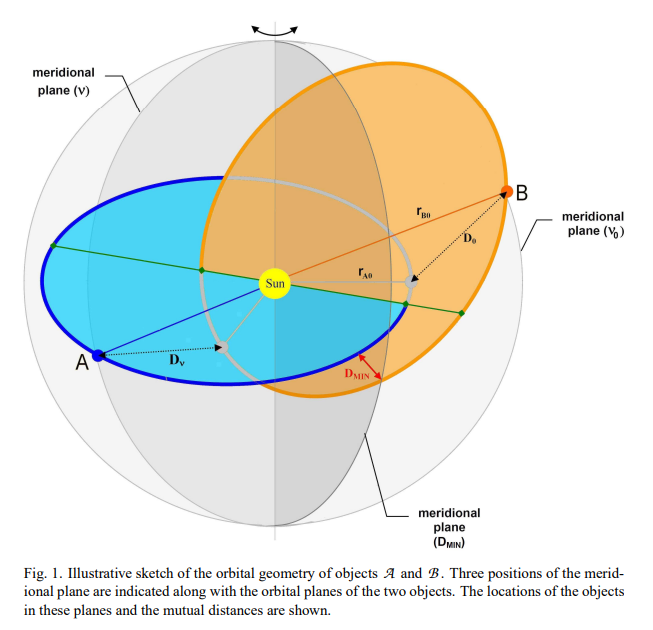

De este conjunto de distancias, se toma la distancia mínima. A este valor le corresponden puntos coplanares para $c_{1_i}$ y $c_{2_i}$. Se procede a tomar los puntos $c_{n_{i-1}}$ y $c_{n_{i+i}}$ de cada cuerpo y se calculan las distancias entre todos ellos (combinatoria) (Fig. 3)

Nuevamente se escoge la distancia mínima entre estos conjuntos y se establecen puntos alrededor de aquellos que obtuvieron la distancia mínima. Esta nueva iteración disminuye el ancho al que se generan los puntos vecinos de modo que, en cada iteración se reduce el ancho y el algoritmo mejora la convergencia a la distancia mínima real (*MOID*). El número de iteraciones se define por un valor de precisión que establece el usuario.

*Si requiere mayor detalle sobre este método, dirijase al paper disponible en el enlace adjunto.

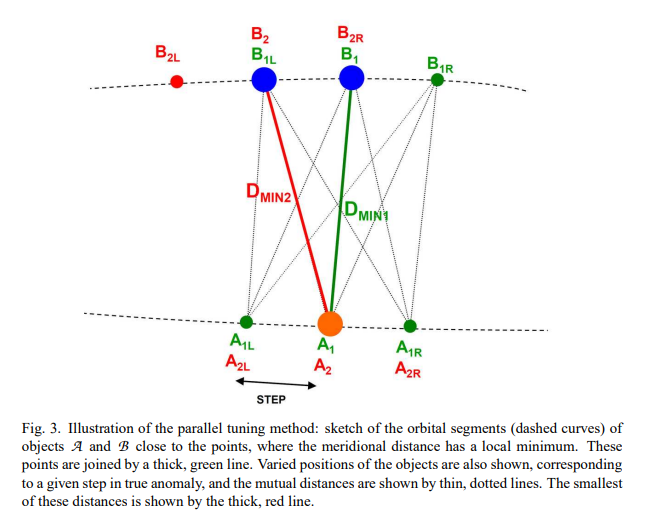

#**Explicación de la función**

Se da la implementación del método descrito anteriormente en la función `moid()`.

El paper menciona que es óptimo generar puntos sobre la órbita de $c_2$ con separaciones angulares de $\sim 0.12\,rad$. Esto equivale a una partición de la órbita en alrededor de 52 puntos.

Luego del barrido del plano meridional, la cantidad de puntos vecinos tomados son 5 junto con el identificado, de modo que se calculan 25 distancias. Para cada iteración se toman los puntos desde $f_{i-2}$ hasta $f_{i+2}$ y se realizan 9 particiones de este intervalo de las cuales se toman los 5 valores centrales. Esto se traduce en aplicar un factor de 0.4 a la separación que tienen los puntos entre sí. El paper realiza una aplicación de factor de 0.15 para hacer más óptimo el cálculo; sin embargo, para nuestros propositos, el valor definido se puede considerar suficiente.

En general, el número de distancias calculadas dependerá del número de iteraciones que se realicen. Se sigue que el número de distancias es

$$N_{inicial} + 25n$$

Este número de distancias calculadas es de gran importancia pues establece la eficiencia del método en lugar de aplicar un barrido punto a punto entre las órbitas. Para alcanzar la precisión que este método logra, se requerirían del órden de $10^3$ puntos en cada órbita para el barrido convencional, por lo que las distancias calculadas serían del orden de $10^6$.

Finalmente, luego de ejecutada la función `moid()`, se retorna el valor del *MOID* y las posiciones de cada cuerpo en las que se da esta mínima distancia.



In [ ]:
# @title
def moid(orb_el1, orb_el2, N_i, N_iter):

  #Parametros del cuerpo 1 para construcción de matriz de transformación
  Omega1, I1, w1 = orb_el1[4:]*deg2rad
  M1 = spy.eul2m(w1, I1, Omega1, 3, 1, 3)
  M1_T = spy.invert(M1)

  #Definición de valores de f2 para barrido orbital del cuerpo 2
  f02 = orb_el2[3]*deg2rad
  f2s = np.linspace(f02, 2*np.pi + f02, N_i)
  r2vecs_obs = orbit(orb_el2, f2s)
  r2vecs = r2vecs_obs @ M1_T

  #Asignación del respectivo f1 para cada f2 (proyección de c2 sobre c1)
  f1s = np.arctan2(r2vecs[:,1], r2vecs[:,0])
  r1vecs_obs = orbit(orb_el1, f1s)
  r1vecs = r1vecs_obs @ M1_T

  #Identificación de mínimo del plano meridional
  ds = np.linalg.norm(r2vecs - r1vecs, axis = 1)
  i = np.argmin(ds)
  j = i.copy()

  #Mejoramiento del MOID
  best_f2s = f2s.copy()
  best_f1s = f1s.copy()
  for l in range(N_iter):

    #Generación de los puntos vecinos y reducción de su separación
    best_f2s = np.linspace(best_f2s[i-2], best_f2s[i+2], 9)
    r2vecs = orbit(orb_el2, best_f2s[2:7]) @ M1_T

    best_f1s = np.linspace(best_f1s[j-2], best_f1s[j+2], 9)
    r1vecs = orbit(orb_el1, best_f1s[2:7]) @ M1_T

    best_N = 5
    best_ds = np.zeros((best_N, best_N))

    #Combinatoria de distancias
    for m in range(best_N):
      for n in range(best_N):
        best_ds[m,n] = np.linalg.norm(r2vecs[m] - r1vecs[n])

    #Identificación de distancia mínima
    d_moid = np.min(best_ds)

    #Identificación de los puntos que generan la distancia mínima
    i, j = np.where(best_ds == d_moid)

    #se establece la posición en cada órbita del sistema heliocentrico
    r1moid = spy.mxv(M1_T, r1vecs[j[0]])
    r2moid = spy.mxv(M1_T, r2vecs[i[0]])

    #Se preparan la siguiente iteración
    i = i[0] + 2
    j = j[0] + 2

  #Retornamos distancia MOID y los puntos sobre las órbitas que lo generan
  return d_moid, r1moid, r2moid

En esta celda se ejecuta la función `moid()` y se visualiza un `DataFrame`la distancia calculada junto el número de iteraciones que se dieron para llegar a dicho valor.

Se muestra que con 8 iteraciones del método fue suficiente para alcanzar el valor de MOID que se encuentra en las bases de datos. En total el número de distancias calculadas son 252.

In [ ]:
# @title
N_iter = 8
d_moid, rmoid_ea, rmoid_ap = moid(orbel_ea, orbel_ap, 52, N_iter)

pd.DataFrame([d_moid, d_moid*UL*1e-3, N_iter],
             index = ['MOID (AU)', 'MOID (km)', 'N (Iter)'],
             columns = ['Earth - Apophis'])

,Earth - Apophis
MOID (AU),0.000258
MOID (km),38602.901254
N (Iter),8.000000




---



#**Kepler Solution**

En esta sección definimos la función `time_solve()`, la cual recibe los elementos orbitales y la fecha (o fechas) a las que se desea propagar la posición sobre la órbita. Esta función calcula las anomalias verdaderas futuras y mediante la funció `orbit()` se construye la orbita del cuerpo respecto al sistema Heliocentrico. Se es cuidadoso con mantener los valores de anomalia en el rango [0, 2π]

In [82]:
# @title
def time_solve(elements, jd):

  #Elementos orbitales necesarios
  f0 = elements[3]*deg2rad
  a, e, n = elements[:3]
  n = n*deg2rad

  #Se establecen las anomalias iniciales
  E0 = 2*np.arctan((((1-e)/(1+e))**0.5)*np.tan(f0/2))
  M0 = E0 - e*np.sin(E0)
  jd_i = jd[0]

  #Se calculan las anomalias futuras para cada fecha
  N = len(jd)
  Ms = (M0 + n*(jd - jd_i))%(2*np.pi)
  Es = np.zeros(N)

  #Se soluciona la anomalia excentrica para cada fecha
  for i, M in enumerate(Ms):
    Es[i] = pc.kepler_newton(Ms[i], e, delta = 1e-14)[0]

  #Calculo de las anomalias verdaderas para cada fecha
  fs = np.arctan2(((1 - e**2)**0.5)*np.sin(Es), np.cos(Es)-e)

  #Recurrimos a la función de calculo de órbita
  rvecs = orbit(elements, fs)

  #Retornamos vectores posición en el sistema Heliocentrico
  return rvecs

Aquí ejecutamos la función `time_solve()` y obtenemos las posiciones futuras de la Tierra y Apophis para fechas entre *2023-06-30* y *2038-06-30*

In [83]:
# @title
rvecs_kepler_ea = time_solve(orbel_ea, jds)
rvecs_kepler_ap = time_solve(orbel_ap, jds)

Para el calculo de las distancias entre los cuerpos definimos la función `date_approach()` la cual recibe las posiciones de cada cuerpo en el tiempo y mediante la función `scipy.signal.find_peaks()` se encuentran los N mínimos principales en sus respectivas fechas. Esto se da con el fin de verificar las aproximaciones del año *2029* y *2036*.



In [84]:
# @title
def date_approach(r1, r2, jd, N):

  #Calculo de distancias en el tiempo
  ds = np.linalg.norm(r1 - r2, axis = 1)

  #Encuentra los mínimos que se encuentren separados por más de un mes
  i, _ = find_peaks(-ds, distance = 90)

  #Toma las N distancias mínimas
  N_min = np.sort(ds[i])[:N]

  #Toma los respectivos Julian days para cada distancia
  i_approach = np.where(np.isin(ds, N_min))[0]
  jd_dates = jd[i_approach]
  d_approach =ds[i_approach]

  #Retornamos distancias y fecha respectiva
  return ds, d_approach, jd_dates

Aquí ejecutamos `date_approach()` y mostramos los resultados obtenidos

In [85]:
# @title

#Calculamos distancias y fechas
ds_kepler, dmin_kepler, jds_dmin_kepler = date_approach(rvecs_kepler_ea,
                                            rvecs_kepler_ap,
                                            jds, 3)

#Convertimos de JD a Calendario
dates_dmin_kepler = Time(jds_dmin_kepler, format = 'jd').iso

#Mostramos información
pd.DataFrame(dmin_kepler*au/1e3,
             columns = ['Distance (km)'],
             index = dates_dmin_kepler)

/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning:

ERFA function "d2dtf" yielded 3 of "dubious year (Note 5)"



,Distance (km)
2029-04-06 00:00:00.000,7.815910e+06
2035-12-24 17:33:51.285,3.658243e+07
2037-03-27 20:46:55.642,9.192698e+06


**Discusión:** La solución analítica considera sistemas de 2 cuerpos aislados de influencias externas, por lo que las órbitas son invariantes en el tiempo. Esta invarianza se da sobre todos los elementos órbitales de modo que el cuerpo siempre recorre la órbita con el mismo movimiento medio.

A pesar de esto, la aproximación proporciona algunas ventajas como la simplicidad teórica y la eficiencia computacional al ignorar la evolución simultanea de los N cuerpos presentes. Esta aproximación resulta útil en situaciones simples cuando el objeto de estudio se encuentra lo suficientemente alejado de otros cuerpos como para despreciar sus efectos gravitacionales.

En cualquier caso, esta solución resulta excesivamente simple a medida que el objeto realiza acercamientos a otros cuerpos, pues no se están considerando los efectos que comienzan a hacerse presentes y la aproximación análitica pierde precisición. En especial, el caso de *Apophis* es uno donde, durante la aproximación a la Tierra, su movimiento sobre la órbita aumenta (se está acelerando). La otra situación es sobre la Tierra, donde su movimiento medio resulta ser menor al de la órbita osculatriz que siempre recorre en la solución análitica, por lo que la Tierra 'análitica' siempre va por delante de la Tierra 'real'.

La solución análitica que consideramos para la Tierra claramente no consideraba la presencia de la luna, que no es insignificante pues los efectos gravitacionales son del orden de milesimas comparados con los efectos del Sol. Estas milesimas son las responsables en el cambio de los elementos órbitales de la Tierra y por tanto, del retraso en su órbita respecto a la solución analítica.

Bajo esta solución, la fecha de máxima aproximación se da en *2029-04-06* con una distancia de ~7.81 millones de kilometros. Esta fecha, aunque se encuentra en el año y mes estimado, discrepa en una semana. Quizá esto no se vea tan grave, pues nos da a entender que mediante la aproximación análitica podemos establecer rangos posibles de acercamiento. Lo importante aquí, más allá del desfase temporal, es que la distancia de aproximación calculada difiere en dos órdenes de magnitud respecto a la que se estima desde *NASA*; esto confirma lo discutido en el parrafo anterior, donde la Tierra 'análitica' se adelanta en la órbita y el asteroide 'análitico' no se acelera. Finalmente, todos estos efectos resultan en una mala predicción de la distancia de aproximación pues estos dos órdenes de magnitud se traducen en una aproximación con distancias mayores a la distancia *Tierra - Luna*.

Respecto a la segunda fecha de aproximación que planteamos (*2036-04-13*), bajo esta solución no logró dicha estimación, sin embargo el método resuelve dos fechas entre los años *2035* y *2037*. En las siguientes secciones analizaremos las aproximaciones adicionales de los datos reales de *JPL - Horizons*



In [97]:
# @title
fig = go.Figure()

fig.update_layout(
    title = "Earth's and Apophis's Orbits (Kepler Solution)",
    width = 800, height = 600,
    title_x = 0.5)

fig.add_trace(go.Scatter3d(
              x = rvecs_kepler_ea[:, 0],
              y = rvecs_kepler_ea[:, 1],
              z = rvecs_kepler_ea[:, 2],
              mode='markers', name = 'Earth',
              marker = dict(size = 2)))

fig.add_trace(go.Scatter3d(
              x = rvecs_kepler_ap[:, 0],
              y = rvecs_kepler_ap[:, 1],
              z = rvecs_kepler_ap[:, 2],
              mode = 'markers', name = 'Apophis',
              marker = dict(size = 2)))

fig.add_trace(go.Scatter3d(
              x = [0], y = [0], z = [0],
              mode = 'markers', name = 'Sun',
              line = {'color': 'yellow'}, marker = dict(size = 10)))

fig.add_trace(go.Scatter3d(
              x = [rmoid_ea[0]], y = [rmoid_ea[1]], z = [rmoid_ea[2]],
              mode = 'markers', name = "Earth's Orbit MOID",
              line = {'color': 'blue'}, marker = dict(size = 5)))

fig.add_trace(go.Scatter3d(
              x = [rmoid_ap[0]], y = [rmoid_ap[1]], z = [rmoid_ap[2]],
              mode = 'markers', name = "Apophis's Orbit MOID",
              line = {'color': 'red'}, marker = dict(size = 4)))

fig.show()



---



#**JPL Horizons Solution**

En esta sección obtenemos los datos reales de posición desde el sistema *JPL - Horizons* y realizamos el calculo de las distancias de aproximación en el tiempo.

In [101]:
# @title
rvecs_jpl_ea = earth_state[:, 0:3]
rvecs_jpl_ap = apophis_state[:, 0:3]

In [98]:
# @title

#Calculamos distancias y fechas de aproximación
jpl_ds, jpl_dmin, jds_dmin_jpl = date_approach(rvecs_jpl_ea, rvecs_jpl_ap, jds, 3)

#Convertimos de Julian Day a Calendario
dates_dmin_jpl = Time(jds_dmin_jpl, format = 'jd').iso

#Mostramos la información
pd.DataFrame(jpl_dmin*au/1e3,
             columns = ['Distance (km)'],
             index = dates_dmin_jpl)

/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning:

ERFA function "d2dtf" yielded 3 of "dubious year (Note 5)"



,Distance (km)
2029-04-13 22:00:00.000,3.841068e+04
2036-03-27 00:00:00.000,4.633452e+07
2037-09-27 12:28:09.385,3.351110e+07


**Discusión:** Como era de esperarse, un análisis con base en datos reales nos da las soluciones reales al problema de la aproximación de *Apophis*. Con estos datos de *JPL - Horizons* se predice una fecha de aproximación *2029-04-13 22:00:00.000*. De acuerdo con Vallejo et. al. (2021), la fecha estimada de aproximación se da en *2029-04-13 21:50:00*; esta fecha resulta en 10 minutos de diferencia respecto a la que calculamos (se habría logrado mayor precisión al incluir más observaciones con menores diferencias de tiempo).

Con una fecha precisa de aproximación, y con datos que consideran los efectos gravitacionales, se tiene una distancia de aproximación de ~*38.000 km*. Observamos la gran diferencia entre este valor y el obtenido mediante la solución analítica.

Respecto a los efectos gravitacionales, algo importante a notar es el cambio en la trayectoria de Apophis. Esto no ocurría en la solución análitica (órbitas invariantes) y refleja un gran problema en la modelación de los sistemas pues a partir de dichos instantes se pierde completamente la validez de la solución futura. En este sentido, una solución de *N-Cuerpos* resulta mucho más apropiada para corregir estos efectos.

No podemos concluir que una solución completa de *N-Cuerpos* sea la ideal debido a que la solución analítica resulta conveniente y precisa en sistemas simples; tampoco podemos asumir siempre una solución de *2 Cuerpos* que claramente desprecia efectos cruciales en la dinámica. Todo recae en los recursos computacionales y en cómo se optimizan sin perder precisión en las soluciones.

Planteamos que habría una segunda fecha de aproximación en el año 2036. Con los datos de *JPL* se resuelve que incluso hay una fecha en 2037 con distancia de aproximación menor a la de 2036. Igualmente, aunque se pensaba que la segunda aproximación se daba en *2036-04-13*, realmente se da para *2036-03-27* lo que resulta muy curioso pues los modelos e investigaciones apuntaban con alarmas a a que esta aproximación tenía riesgo de colisión. De hecho, para esta fecha resolvemos distancias del orden de millones de kilometros lo cual no es siquiera indicio de riesgo. Se debe revisar un poco mejor este resultado y verificar realmente lo que sucederá para aquella fecha.

- Agustín Vallejo, Jorge I Zuluaga, Germán Chaparro, Conditions for high-resolution bistatic radar observations of Apophis in 2029, Monthly Notices of the Royal Astronomical Society, Volume 518, Issue 3, January 2023, Pages 4438–4448, https://doi.org/10.1093/mnras/stac3046

In [108]:
# @title

#Encontramos la posición de los cuerpos en la aproximación
i = np.argmin(jpl_ds)
earth_approach = rvecs_jpl_ea[i]
apophis_approach = rvecs_jpl_ap[i]

In [112]:
# @title
fig = go.Figure()

fig.update_layout(
    title = "Earth's and Apophis's Real Orbits (JPL Data)",
    width = 800, height = 600,
    title_x = 0.5)

fig.add_trace(go.Scatter3d(
              x = rvecs_jpl_ea[:, 0],
              y = rvecs_jpl_ea[:, 1],
              z = rvecs_jpl_ea[:, 2],
              mode='markers', name = 'Earth',
              marker = dict(size = 2)))

fig.add_trace(go.Scatter3d(
              x = rvecs_jpl_ap[:, 0],
              y = rvecs_jpl_ap[:, 1],
              z = rvecs_jpl_ap[:, 2],
              mode = 'markers', name = 'Apophis',
              marker = dict(size = 2)))

fig.add_trace(go.Scatter3d(
              x = [0], y = [0], z = [0],
              mode = 'markers', name = 'Sun',
              line = {'color': 'yellow'},
              marker = dict(size = 10)))

fig.add_trace(go.Scatter3d(
              x = [earth_approach[0]],
              y = [earth_approach[1]],
              z = [earth_approach[2]],
              mode = 'markers',
              line = {'color': 'blue'},
              name = 'Earth Approach (2029)',
              marker = dict(size = 6)))

fig.add_trace(go.Scatter3d(
              x = [apophis_approach[0]],
              y = [apophis_approach[1]],
              z = [apophis_approach[2]],
              mode = 'markers',
              line = {'color': 'red'},
              name = 'Earth Approach (2029)',
              marker = dict(size = 5)))

fig.show()



---



#**Approach Dates**

Aquí observamos como evoluciona la distancia entre la *Tierra* y *Apophis* en el tiempo. En perspectiva general, las distancias disminuyen y aumentan, con algunas pequeñas periodicidades debido al movimiento órbital simultaneo de los cuerpos.

En ambas curvas notamos comportamientos similares. Esto, en primer vistazo, concluiría una buena aproximación de la solución analítica, aunque cuántificar qué tan 'buena' es la solución es el verdadero problema que debemos abordar de forma numérica.

Mostramos las tres fechas de máxima aproximación que fueron resultas.

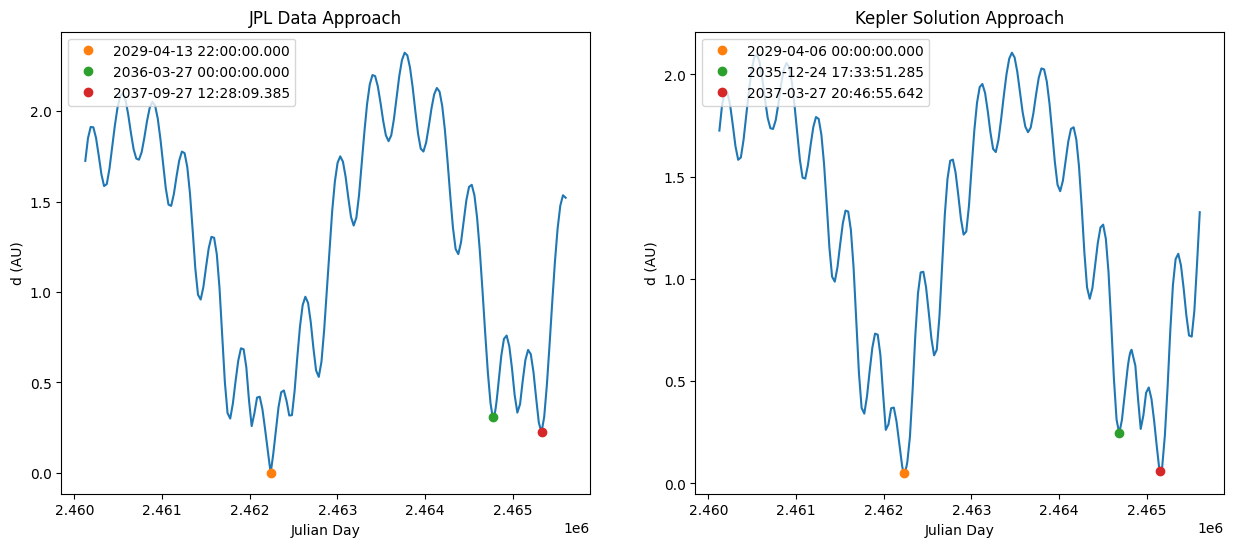

In [146]:
# @title

#Aproximación en el tiempo - JPL
plt.figure(figsize = (15,6))

plt.subplot(1,2,1)
plt.plot(jds, jpl_ds)

for i in range(len(jpl_dmin)):
  plt.plot(jds_dmin_jpl[i], jpl_dmin[i], 'o',
          label = dates_dmin_jpl[i])

plt.title('JPL Data Approach')
plt.xlabel('Julian Day')
plt.ylabel('d (AU)')
plt.legend(loc = 'upper left')

#Aproximación en el tiempo - Kepler Solution
plt.subplot(1,2,2)
plt.plot(jds, ds_kepler)

for i in range(len(dmin_kepler)):
  plt.plot(jds_dmin_kepler[i], dmin_kepler[i], 'o',
          label = dates_dmin_kepler[i])

plt.xlabel('Julian Day')
plt.ylabel('d (AU)')
plt.legend(loc = 'upper left')
plt.title('Kepler Solution Approach')

plt.show()

En esta sección analizamos la diferencia númerica entre las soluciones de distancia entre la *Tierra* y *Apophis*. Podemos observar que el error se propaga en el tiempo; inicialmente se tiene una propagación gradual y controlada, pero a partir de cierta fecha se disparan las discrepancias. En el DataFrame de celdas abajo podemos apreciar el error inicial entre las soluciones era del orden de unos cuantos metros, y luego al primer mes esta discrepancia se eleva al orden de las decenas de millones de kilometros.

Con esto es suficiente para afirmar que la solución análitica es imprecisa en el tiempo para sistemas que no son aislados o en eventos de aproximación de cuerpos. Esto no significa que la solución sea inutil, solo nos dice que no es suficiente debido a lo simple que es. La *Teoría de Perturbaciones* nos permitirá generalizar esta solución de modo que se haga más precisa para este tipo de situaciones.

In [147]:
# @title
error = np.abs(jpl_ds - ds_kepler)

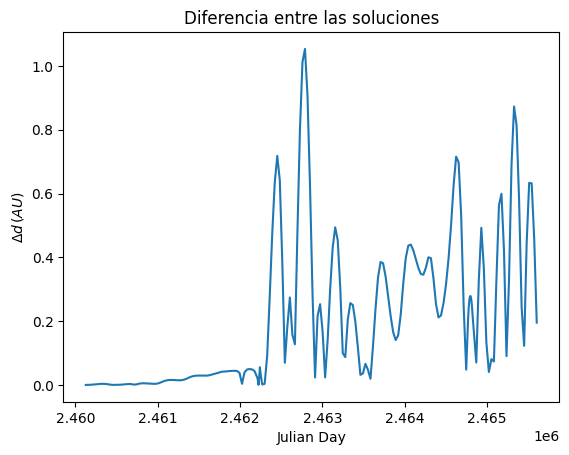

In [151]:
# @title
plt.plot(jds, error)
plt.title('Diferencia entre las soluciones')
plt.ylabel('$\Delta d\,(AU)$')
plt.xlabel('Julian Day')
plt.show()

In [149]:
# @title
pd.DataFrame(error, index = Time(jds, format = 'jd').iso, columns = ['Error (AU)'])

/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning:

ERFA function "d2dtf" yielded 346 of "dubious year (Note 5)"



,Error (AU)
2023-06-30 00:00:00.000,1.398881e-14
2023-07-30 14:36:52.290,1.811541e-04
2023-08-30 05:13:44.581,5.573838e-04
2023-09-29 19:50:36.872,1.113644e-03
2023-10-30 10:27:29.162,1.836179e-03
...,...
2038-02-27 13:32:30.838,4.441583e-01
2038-03-30 04:09:23.128,6.335358e-01
2038-04-29 18:46:15.419,6.319172e-01
2038-05-30 09:23:07.710,4.573245e-01
